# Sequential CRM Experiments

## Reference works
- ref paper: https://arxiv.org/pdf/1502.02362.pdf
- ref code & data: https://www.cs.cornell.edu/~adith/POEM/
- recent paper (ICML'18): http://proceedings.mlr.press/v80/wu18g/wu18g.pdf
- recent paper using vision tasks: https://arxiv.org/pdf/1806.11500v6.pdf

TODO:
1. DONE - fix pi0 to be bad enough
1. DONE - make sure propensities are not all 0
1. DONE - add check for propensity overfitting
1. SEEMS OK - fix optim to work correctly -- but POEM cannot work with LBFG-S (see paper)

In [1]:
import sys
import time
import copy

In [2]:
import numpy as np

In [3]:
import jax.numpy as jnp
from jax.scipy.special import expit as jexpit

In [4]:
import matplotlib.pyplot as plt

In [5]:
from dataset_utils import load_dataset
from baselines_skylines import result_table, make_baselines_skylines
from crm_dataset import CRMDataset
from crm_model import Model
from tracing_utils import LossHistory

---
### Loading dataset

In [6]:
# dataset_name='scene'
dataset_name='yeast'
# dataset_name='tmc2007'

X_train, y_train, X_test, y_test, labels = load_dataset(dataset_name)

X_train: (1812, 104) y_train: (1812, 14)


### Baselines & Skylines

In [7]:
pi0, pistar = make_baselines_skylines(dataset_name, X_train, y_train)

In [8]:
sampling_probas = pi0.predict_proba(X_train)
sampling_probas = np.array([_[:,1] for _ in sampling_probas]).T 

In [9]:
sampling_probas.min(axis=0)

array([0.04196816, 0.07985135, 0.07448589, 0.01369675, 0.00762209,
       0.01825114, 0.0269684 , 0.02914602, 0.00790334, 0.00671692,
       0.00631266, 0.13104026, 0.13177221, 0.00547145])

In [10]:
log_props_per_instance = jnp.log(sampling_probas).sum(axis=1)
n_zero_props = (jnp.exp(log_props_per_instance) == 0).astype(int).sum()
print(n_zero_props, '/', sampling_probas.shape[0], 'train instances have 0 propensity')
assert (n_zero_props / sampling_probas.shape[0]) < .1

0 / 1812 train instances have 0 propensity


# The Experiment

In [11]:
replay_targets = 2**np.arange(6)
replay_targets

array([ 1,  2,  4,  8, 16, 32])

In [33]:
crm_losses = np.ones((10, len(replay_targets,)))
crm_rewards = np.ones((10, len(replay_targets,)))

for i in range(10):
    print(i, end='')
    np.random.seed(i*42)
    current_replay = 0
    crm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    crm_dataset = CRMDataset()
    for j, replay_target in enumerate(replay_targets):
        print('.', end=' ')
        needed_replays = replay_target - current_replay
        current_replay = replay_target
        crm_dataset.update_from_supervised_dataset(X_train, y_train, sampling_probas, n_samples=needed_replays)
        crm_model.fit(
            crm_dataset, 
            lambda_ = .5,
            verbose = 0
        )
        crm_losses[i,j] = crm_model.expected_hamming_loss(X_test, y_test)    
        crm_rewards[i,j] = (1 - np.logical_xor(crm_model.predict(X_test), y_test)).sum()

crm_losses = crm_losses.mean(axis=0)
crm_rewards = crm_rewards.mean(axis=0)

0. . . . . . 1. . . . . . 2. . . . . . 3. . . . . . 4. . . . . . 5. . . . . . 6. . . . . . 7. . . . . . 8. . . . . . 9. . . . . . 

In [34]:
ucrm_losses = np.ones((10, len(replay_targets,)))
ucrm_rewards = np.ones((10, len(replay_targets,)))

for i in range(10):
    print(i, end='')
    np.random.seed(i*42)
    current_replay = 0
    ucrm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    ucrm_dataset = CRMDataset()
    for j, replay_target in enumerate(replay_targets):
        print('.', end=' ')
        needed_replays = replay_target - current_replay
        current_replay = replay_target
        ucrm_dataset.update_from_supervised_dataset(X_train, y_train, .5*np.ones_like(sampling_probas), n_samples=needed_replays)
        ucrm_model.fit(
            ucrm_dataset, 
            lambda_ = .5,
            verbose = 0
        )
        ucrm_losses[i,j] = ucrm_model.expected_hamming_loss(X_test, y_test)    
        ucrm_rewards[i,j] = (1 - np.logical_xor(ucrm_model.predict(X_test), y_test)).sum()
        
ucrm_losses = ucrm_losses.mean(axis=0)
ucrm_rewards = ucrm_rewards.mean(axis=0)

0. . . . . . 1. . . . . . 2. . . . . . 3. . . . . . 4. . . . . . 5. . . . . . 6. . . . . . 7. . . . . . 8. . . . . . 9. . . . . . 

In [35]:
scrm_losses = np.ones((10, len(replay_targets,)))
scrm_rewards = np.ones((10, len(replay_targets,)))

for i in range(10):
    print(i, end='')
    np.random.seed(i*42)
    current_replay = 0
    scrm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    scrm_dataset = CRMDataset()
    for j, replay_target in enumerate(replay_targets):
        print('.', end=' ')
        needed_replays = replay_target - current_replay
        current_replay = replay_target
        scrm_sampling_probas = scrm_model.predict_proba(X_train, y_train)
        scrm_dataset.update_from_supervised_dataset(X_train, y_train, scrm_sampling_probas, n_samples=needed_replays)
        scrm_model.fit(
            scrm_dataset, 
            lambda_ = -1 / np.sqrt(replay_target),
            verbose = 0
        )
        scrm_losses[i,j] = scrm_model.expected_hamming_loss(X_test, y_test)    
        scrm_rewards[i,j] = (1 - np.logical_xor(scrm_model.predict(X_test), y_test)).sum()

scrm_losses = scrm_losses.mean(axis=0)
scrm_rewards = scrm_rewards.mean(axis=0)

0. . . . . . 1. . . . . . 2. . . . . . 3. . . . . . 4. . . . . . 5. . . . . . 6. . . . . . 7. . . . . . 8. . . . . . 9. . . . . . 

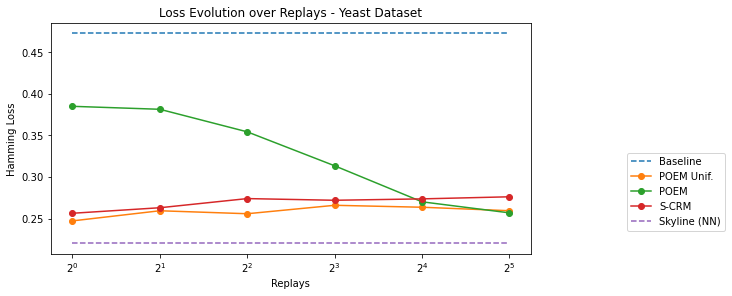

In [15]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,4))
plt.title('Loss Evolution over Replays - Yeast Dataset')
ax.set_xlabel('Replays')
ax.set_xscale('log', base=2)
ax.plot(replay_targets, .473*np.ones_like(replay_targets), '--', label='Baseline')
ax.plot(replay_targets, ucrm_losses, 'o-', label='POEM Unif.')
ax.plot(replay_targets, crm_losses, 'o-', label='POEM')
ax.plot(replay_targets, scrm_losses, 'o-', label='S-CRM')
#ax.plot(replay_targets, .295*np.ones_like(replay_targets), '--', label='Skyline (LR)')
ax.plot(replay_targets, .220*np.ones_like(replay_targets), '--', label='Skyline (NN)')
ax.set_ylabel('Hamming Loss')
ax.legend(loc=(1.2, .1))

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier

In [22]:
mlp = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(500, 100, 40, 10,)), n_jobs=4).fit(X_train, y_train)

MultiOutputClassifier(estimator=MLPClassifier(hidden_layer_sizes=(500, 100, 40,
                                                                  10)),
                      n_jobs=4)

In [29]:
baseline_rewards = (1 - np.logical_xor(pi0.predict(X_test), y_test)).sum()*np.ones_like(crm_rewards)
skyline_rewards = (1 - np.logical_xor(mlp.predict(X_test), y_test)).sum()*np.ones_like(crm_rewards)

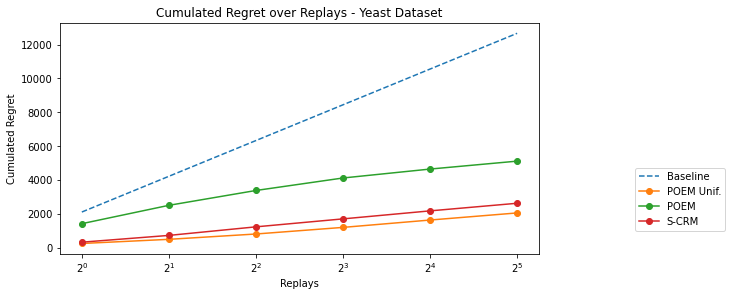

In [40]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,4))
plt.title('Cumulated Regret over Replays - Yeast Dataset')
ax.set_xlabel('Replays')
ax.set_xscale('log', base=2)
ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(baseline_rewards), '--', label='Baseline')
ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(ucrm_rewards), 'o-', label='POEM Unif.')
ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(crm_rewards), 'o-', label='POEM')
ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(scrm_rewards), 'o-', label='S-CRM')
# ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(skyline_rewards), '--', label='Skyline')
ax.set_ylabel('Cumulated Regret')
ax.legend(loc=(1.2, .1))